# Задание 1 — проекционные методы для ОДУ второго порядка

In [11]:
import numpy as np
from numpy.typing import NDArray
from scipy.integrate import quad
from scipy.special import jacobi
from scipy.integrate import solve_bvp
from functools import cache
from typing import Callable
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
# Параметры в задаче Штурма-Лиувилля и краевые условия
a, b = -1, 1
p = lambda x: 1 / (2 + x)
r = lambda x: np.cos(x)
f = lambda x: 1 + x

@cache
def basis_function(i) -> Callable:
    return lambda x: (1 - x**2) * jacobi(i, 1, 1)(x)

In [50]:
def d(f: Callable, h=1.e-3) -> Callable:
    return lambda x: (f(x + h) - f(x - h)) / (2 * h)

def show(y: NDArray, label='y', color='red'):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=200)
    x = np.linspace(-1, 1, len(y))
    plt.plot(x, y, color=color, label=label)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend()
    ax.grid()
    plt.show()

def solve(n) -> NDArray:
    P, R, F = p, r, f
    Q = lambda x: 1 / (2 + x)**2
    def fun(x, y):
        return np.vstack([y[1], (Q(x) * y[1] + R(x) * y[0] - F(x)) / P(x)])
    def bc(ya, yb):
        return np.array([ya[0], yb[0]])
    x = np.linspace(a, b, n)
    y = np.zeros((2, n))
    return solve_bvp(fun, bc, x, y).sol(x)[0]

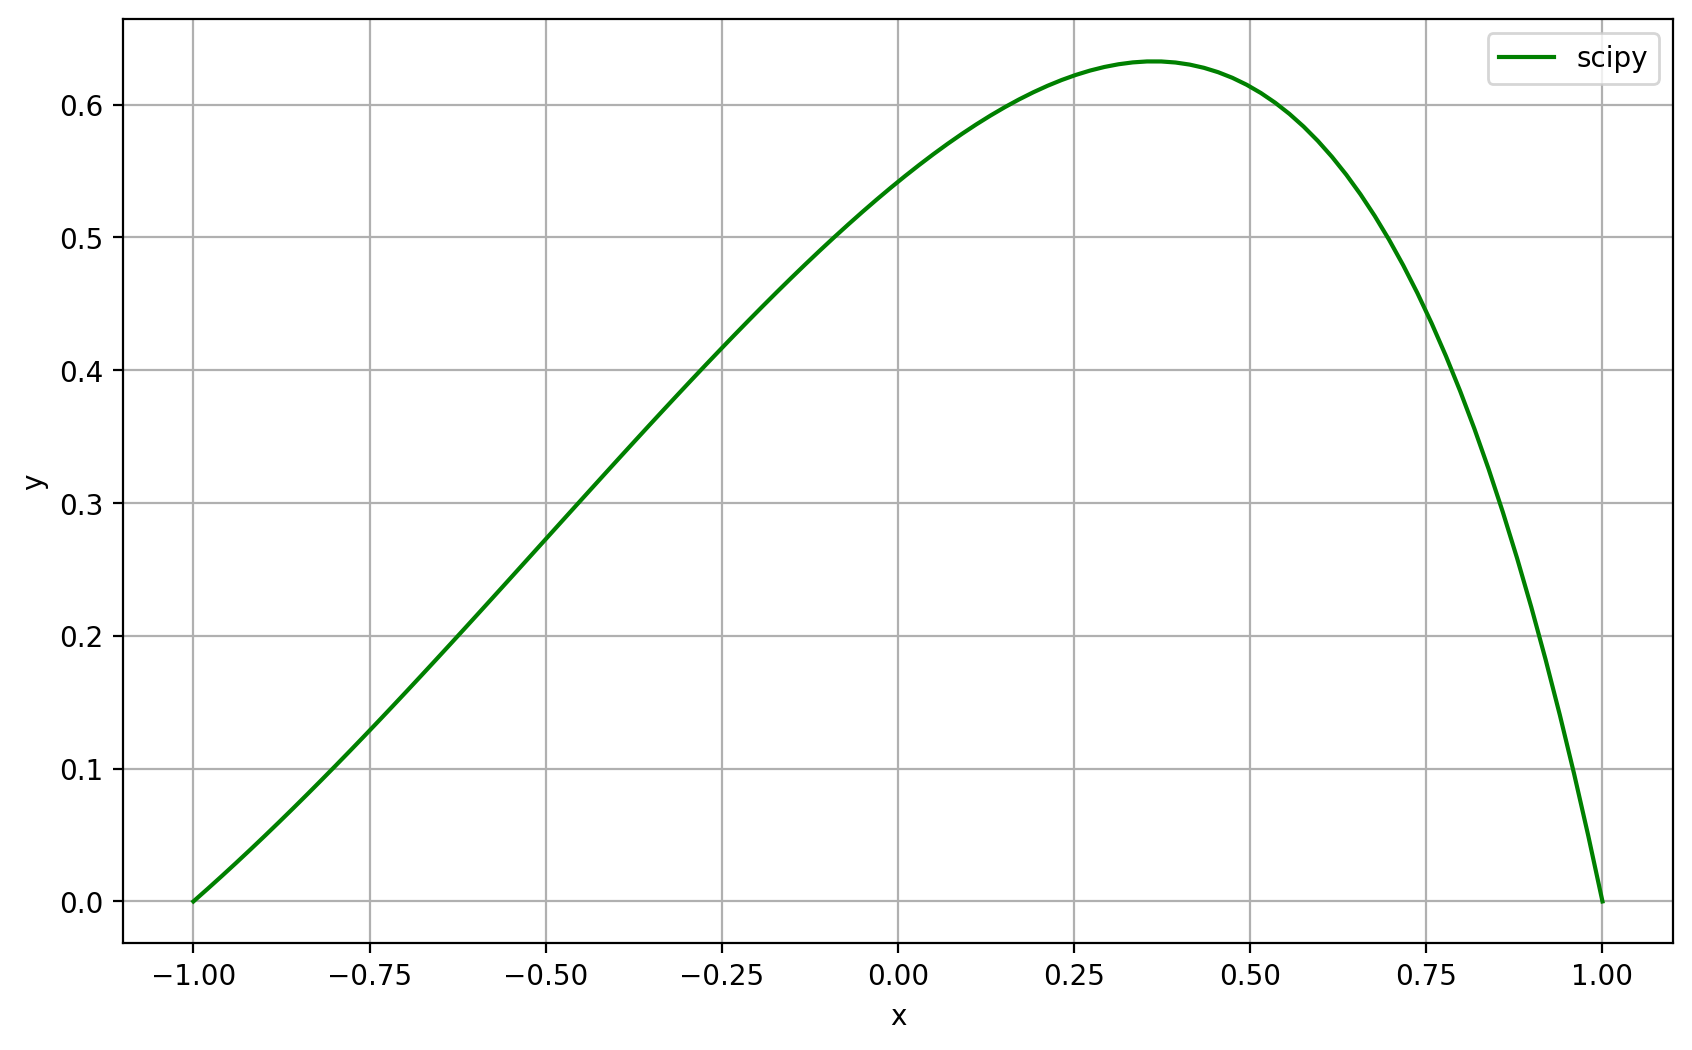

In [51]:
show(solve(100), label='scipy', color='green')

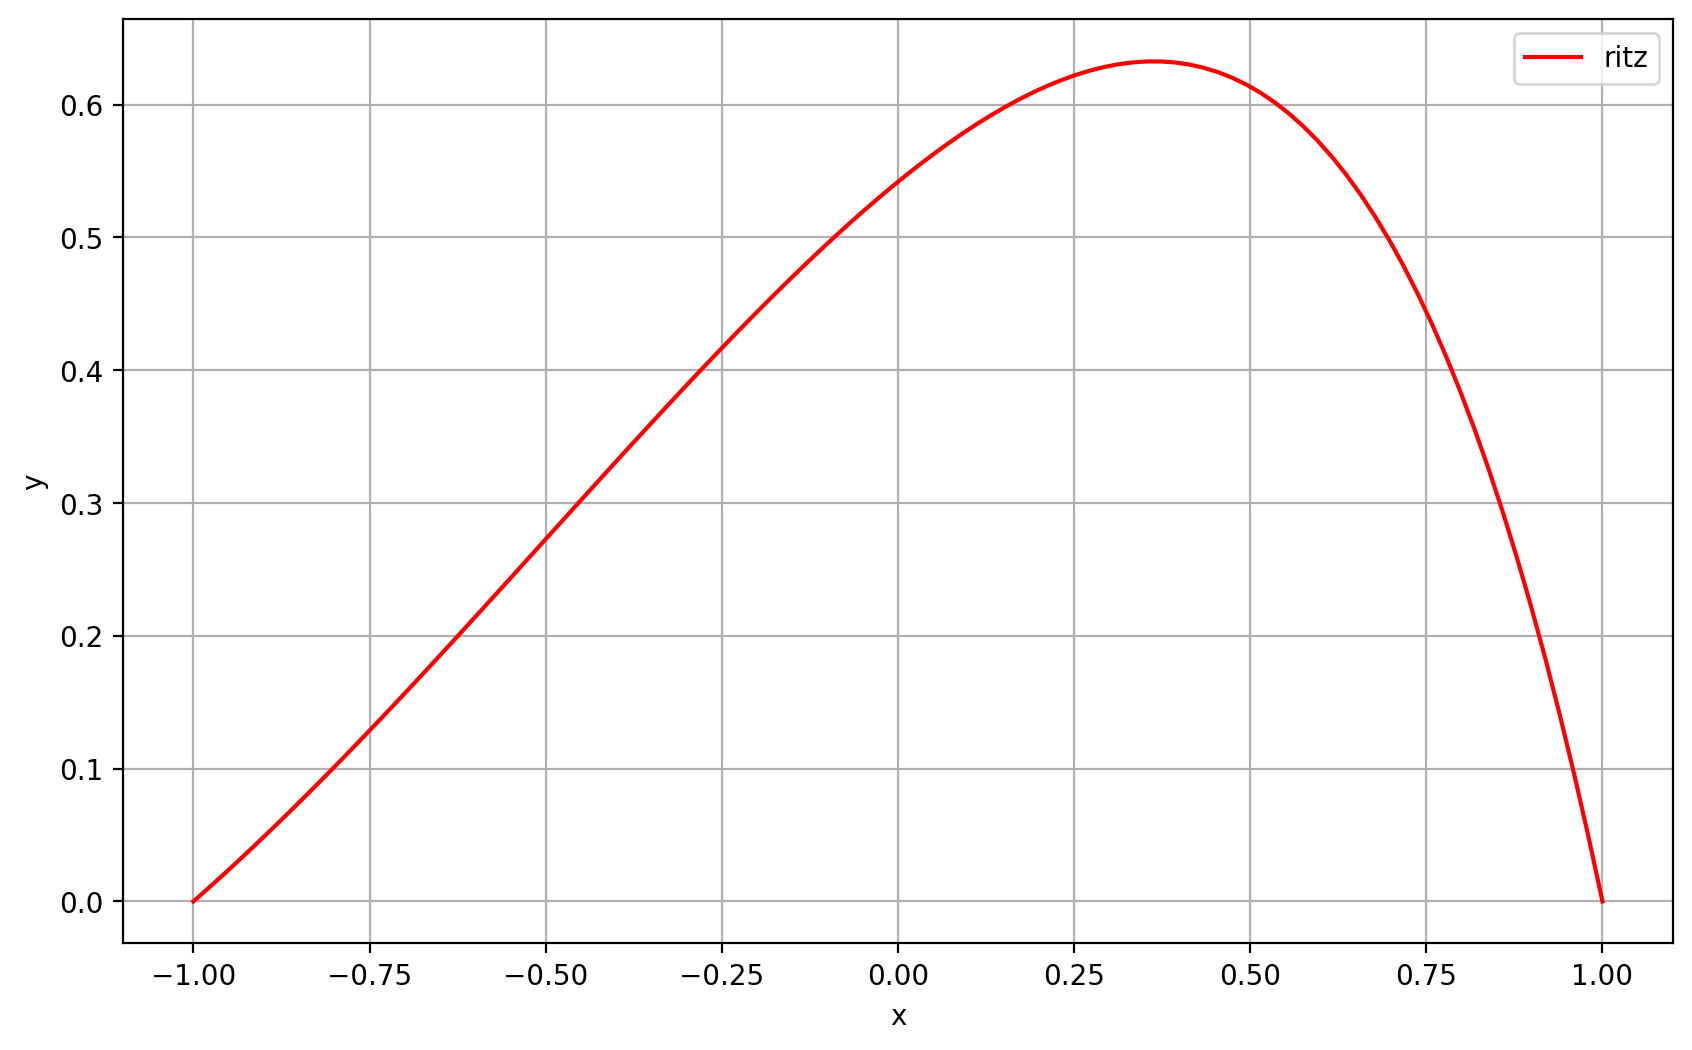

In [54]:
def solve_ritz(n) -> Callable:

    def intergrand(y: Callable, z: Callable) -> Callable:
        return lambda x: p(x) * d(y)(x) * d(z)(x) + r(x) * y(x) * z(x)
    
    A = np.zeros((n, n))
    B = np.zeros(n)

    for i in range(n):
        phi = basis_function(i)
        for j in range(n):
            psi = basis_function(j)
            A[i, j], _ = quad(intergrand(psi, phi), a, b)
        B[i], _ = quad(lambda x: f(x) * phi(x), a, b)

    C = np.linalg.solve(A, B)

    def ans(x):
        u = 0
        for i in range(n):
            u += C[i] * basis_function(i)(x)
        return u

    return ans

u = solve_ritz(10)
show(u(np.linspace(-1, 1, 100)), label='ritz', color='red')

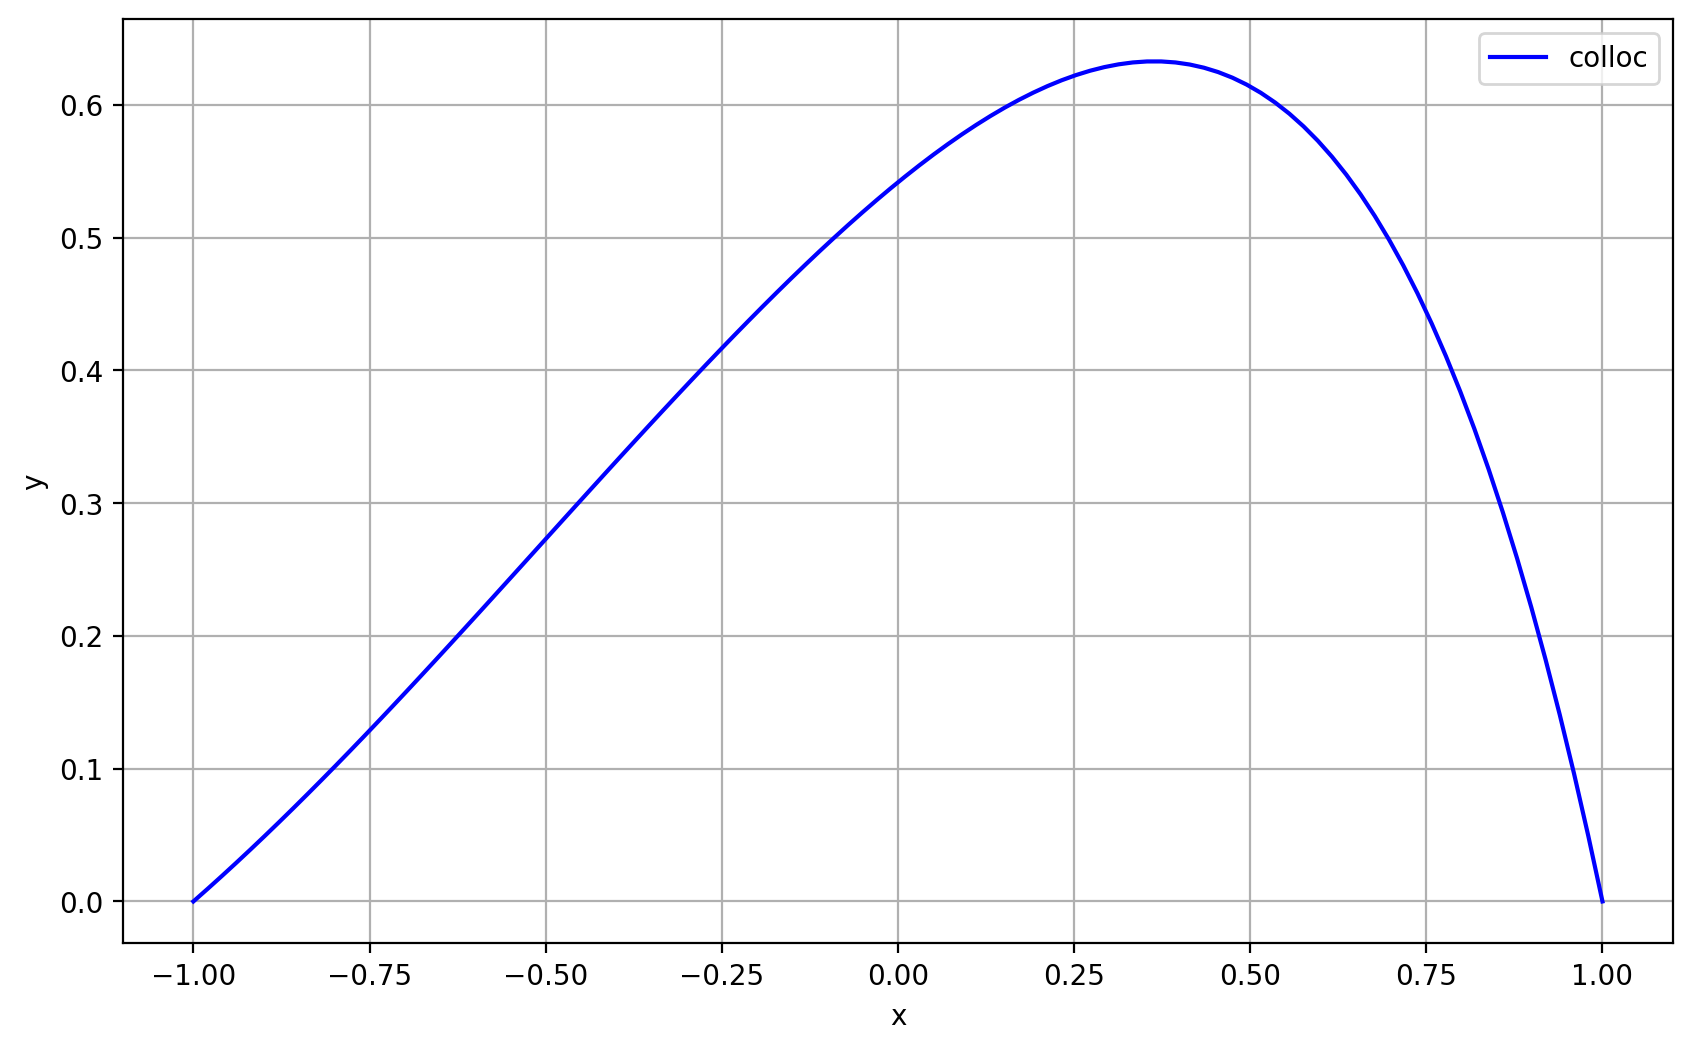

In [53]:
def solve_collocations(n) -> Callable:

    def t(i) -> float:
        """Корень многочлена Чебышева первого рода"""
        return np.cos((2*i - 1) * np.pi / (2 * n))
    
    def L(u: Callable) -> Callable:
        return lambda x: -d(lambda y: p(y) * d(u)(y))(x) + r(x) * u(x)
    
    A = np.zeros((n, n))
    B = np.zeros(n)

    for i in range(n):
        for j in range(n):
            A[i][j] = L(basis_function(j))(t(i+1))
        B[i] = f(t(i+1))

    C = np.linalg.solve(A, B)

    def approximate_solution(x):
        u = 0
        for i in range(n):
            u += C[i] * basis_function(i)(x)
        return u
    
    return approximate_solution

u = solve_collocations(6)
show(u(np.linspace(-1, 1, 100)), label='colloc', color='blue')


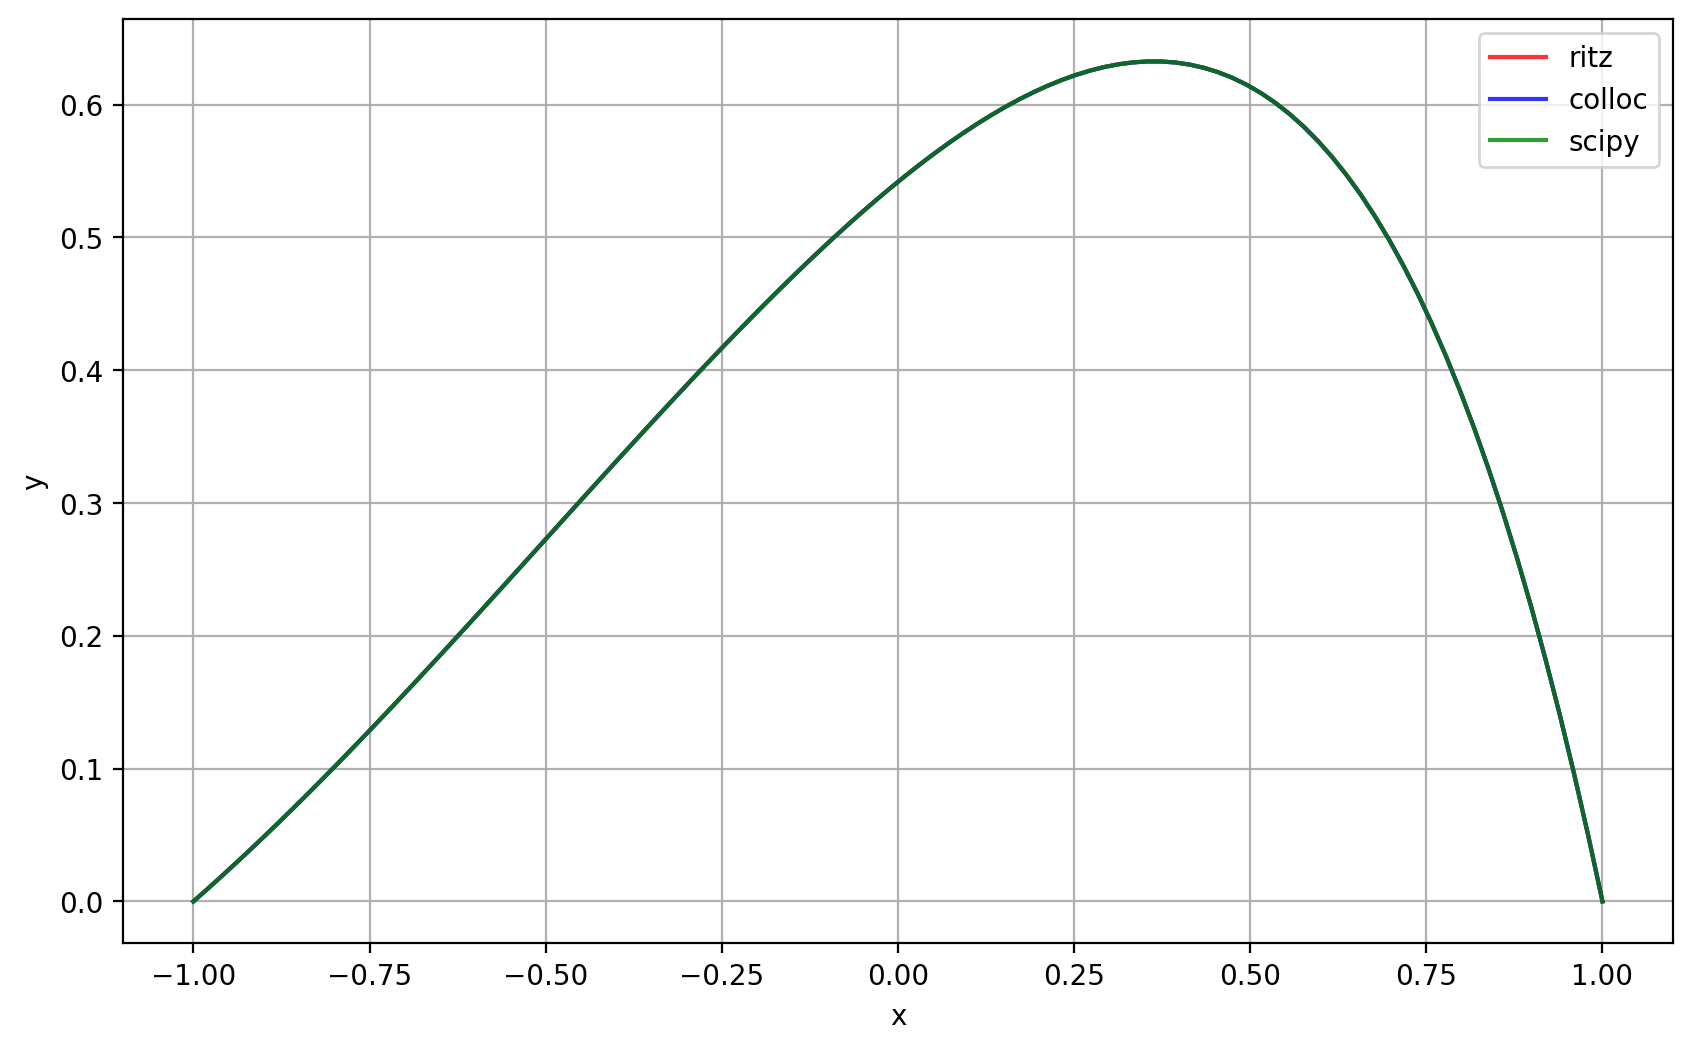

In [48]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)
x = np.linspace(-1, 1, 100)
plt.plot(x, solve_ritz(7)(x), color='red', label='ritz', alpha=0.8)
plt.plot(x, solve_collocations(7)(x), color='blue', label='colloc', alpha=0.8)
plt.plot(x, solve(len(x)), color='green', label='scipy', alpha=0.8)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()
ax.grid()
plt.show()